# Эксперимент: Сравнение моделей Whisper для транскрибации

**ML-инженер:** Софья  
**Дата:** 2025-08-12  
**Цель:** протестировать четыре модели (`tiny`, `base`, `small`, `medium`) на одинаковых аудиофайлах и сравнить качество транскрибации, скорость обработки и потребление памяти.


### Импорт библиотек и настройка окружения

In [85]:
import os, time, psutil, gc
import pandas as pd
import torch
import whisper
from jiwer import wer, cer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

### Конфигурация эксперимента и загрузка данных

In [86]:
CONFIG = {
    'max_memory_mb': 6000,
    'max_cores': 4,
    'sample_size': 20,
    'language': 'ru',
    'random_seed': 42
}

MODELS = ["tiny", "base", "small", "medium"]
DATA_DIR = Path("../data")
AUDIO_DIR = DATA_DIR / "clips"

data_files = {
    'validated': DATA_DIR / "validated.tsv",
    'sentences': DATA_DIR / "validated_sentences.tsv", 
    'other': DATA_DIR / "other.tsv",
    'unvalidated': DATA_DIR / "unvalidated_sentences.tsv",
    'durations': DATA_DIR / "clip_durations.tsv",
    'reported': DATA_DIR / "reported.tsv"
}

validated = pd.read_csv(data_files['validated'], sep="\t")
sentences = pd.read_csv(data_files['sentences'], sep="\t")

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    torch.set_num_threads(CONFIG['max_cores'])

warnings.filterwarnings('ignore')

random.seed(CONFIG['random_seed'])

smoothing = SmoothingFunction().method1

### Анализ всех доступных файлов данных

In [88]:
data = {}
for name, path in data_files.items():
    try:
        data[name] = pd.read_csv(path, sep="\t")
    except Exception as e:
        data[name] = pd.DataFrame()

summary_data = []
for name, df in data.items():
    summary_data.append({
        'Тип данных': name,
        'Количество записей': len(df),
        'Колонки': len(df.columns)
    })

summary_df = pd.DataFrame(summary_data)

summary_df

,Тип данных,Количество записей,Колонки
0,validated,29,13
1,sentences,47231,6
2,other,895,13
3,unvalidated,706,4
4,durations,926,2
5,reported,8,4


### Подготовка данных для эксперимента

In [89]:
all_audio_data = pd.concat([data['validated'], data['other']], ignore_index=True)
all_ref_texts = {row["path"]: row["sentence"] for _, row in all_audio_data.iterrows()}

### Выборка аудио файлов для тестирования

In [90]:
all_audio_files = list(AUDIO_DIR.glob("*.mp3"))
sample_size = min(CONFIG['sample_size'], len(all_audio_files))
audio_files = random.sample(all_audio_files, sample_size)

experiment_results = []
all_detailed_results = []

### Основной цикл тестирования моделей Whisper

In [91]:
for model_name in MODELS:
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()
    
    process = psutil.Process(os.getpid())
    start_mem = process.memory_info().rss / (1024**2)
    start_time = time.time()
    
    model = whisper.load_model(model_name)
    
    peak_mem = start_mem
    detailed_results = []
    successful_files = 0
    
    for i, file in enumerate(audio_files):
        current_mem = process.memory_info().rss / (1024**2)
        if current_mem > CONFIG['max_memory_mb']:
            break
        
        fname = Path(file).name
        ref = all_ref_texts.get(fname)
        if not ref:
            continue
        
        result = model.transcribe(str(file), language=CONFIG['language'])
        hyp = result["text"].strip()
        
        bleu_score = sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothing)
        
        detailed_results.append({
            "audio_file": fname,
            "model": model_name,
            "reference": ref,
            "transcription": hyp,
            "wer": wer(ref, hyp),
            "cer": cer(ref, hyp),
            "bleu": bleu_score,
            "memory_used_mb": current_mem,
            "file_index": i,
            "success": True
        })
        
        successful_files += 1
        peak_mem = max(peak_mem, current_mem)
    
    total_time = time.time() - start_time
    
    experiment_results.append({
        'Модель': model_name,
        'Обработано файлов': f"{successful_files}/{len(audio_files)}",
        'Успешность (%)': f"{successful_files/len(audio_files)*100:.1f}%",
        'Время (сек)': f"{total_time:.1f}",
        'Пиковая память (МБ)': f"{peak_mem:.0f}",
        'Превышение лимита': "Да" if peak_mem > CONFIG['max_memory_mb'] else "Нет"
    })
    
    all_detailed_results.extend(detailed_results)

### Создание DataFrame с результатами эксперимента

In [92]:
results_df = pd.DataFrame(experiment_results)
detailed_df = pd.DataFrame(all_detailed_results)

results_df

,Модель,Обработано файлов,Успешность (%),Время (сек),Пиковая память (МБ),Превышение лимита
0,tiny,20/20,100.0%,20.1,752,Нет
1,base,20/20,100.0%,36.2,1132,Нет
2,small,20/20,100.0%,97.5,2299,Нет
3,medium,20/20,100.0%,321.3,4398,Нет


### Расчет итоговых метрик качества моделей

In [93]:
model_metrics = detailed_df.groupby('model').agg({
    'wer': ['mean', 'std'],
    'cer': ['mean', 'std'],
    'bleu': ['mean', 'std']
}).round(3)

model_scores['overall_score'] = (
    (1 - model_scores['wer']) * 0.4 + 
    (1 - model_scores['cer']) * 0.4 + 
    model_scores['bleu'] * 0.2
)

model_metrics.columns = ['_'.join(col).strip() for col in model_metrics.columns]
model_metrics = model_metrics.reset_index()

model_metrics

,model,wer_mean,wer_std,cer_mean,cer_std,bleu_mean,bleu_std
0,base,0.471,0.298,0.212,0.279,0.306,0.249
1,medium,0.302,0.333,0.160,0.292,0.547,0.365
2,small,0.391,0.325,0.183,0.316,0.373,0.313
3,tiny,0.597,0.351,0.279,0.299,0.240,0.263


### Визуализация результатов эксперимента

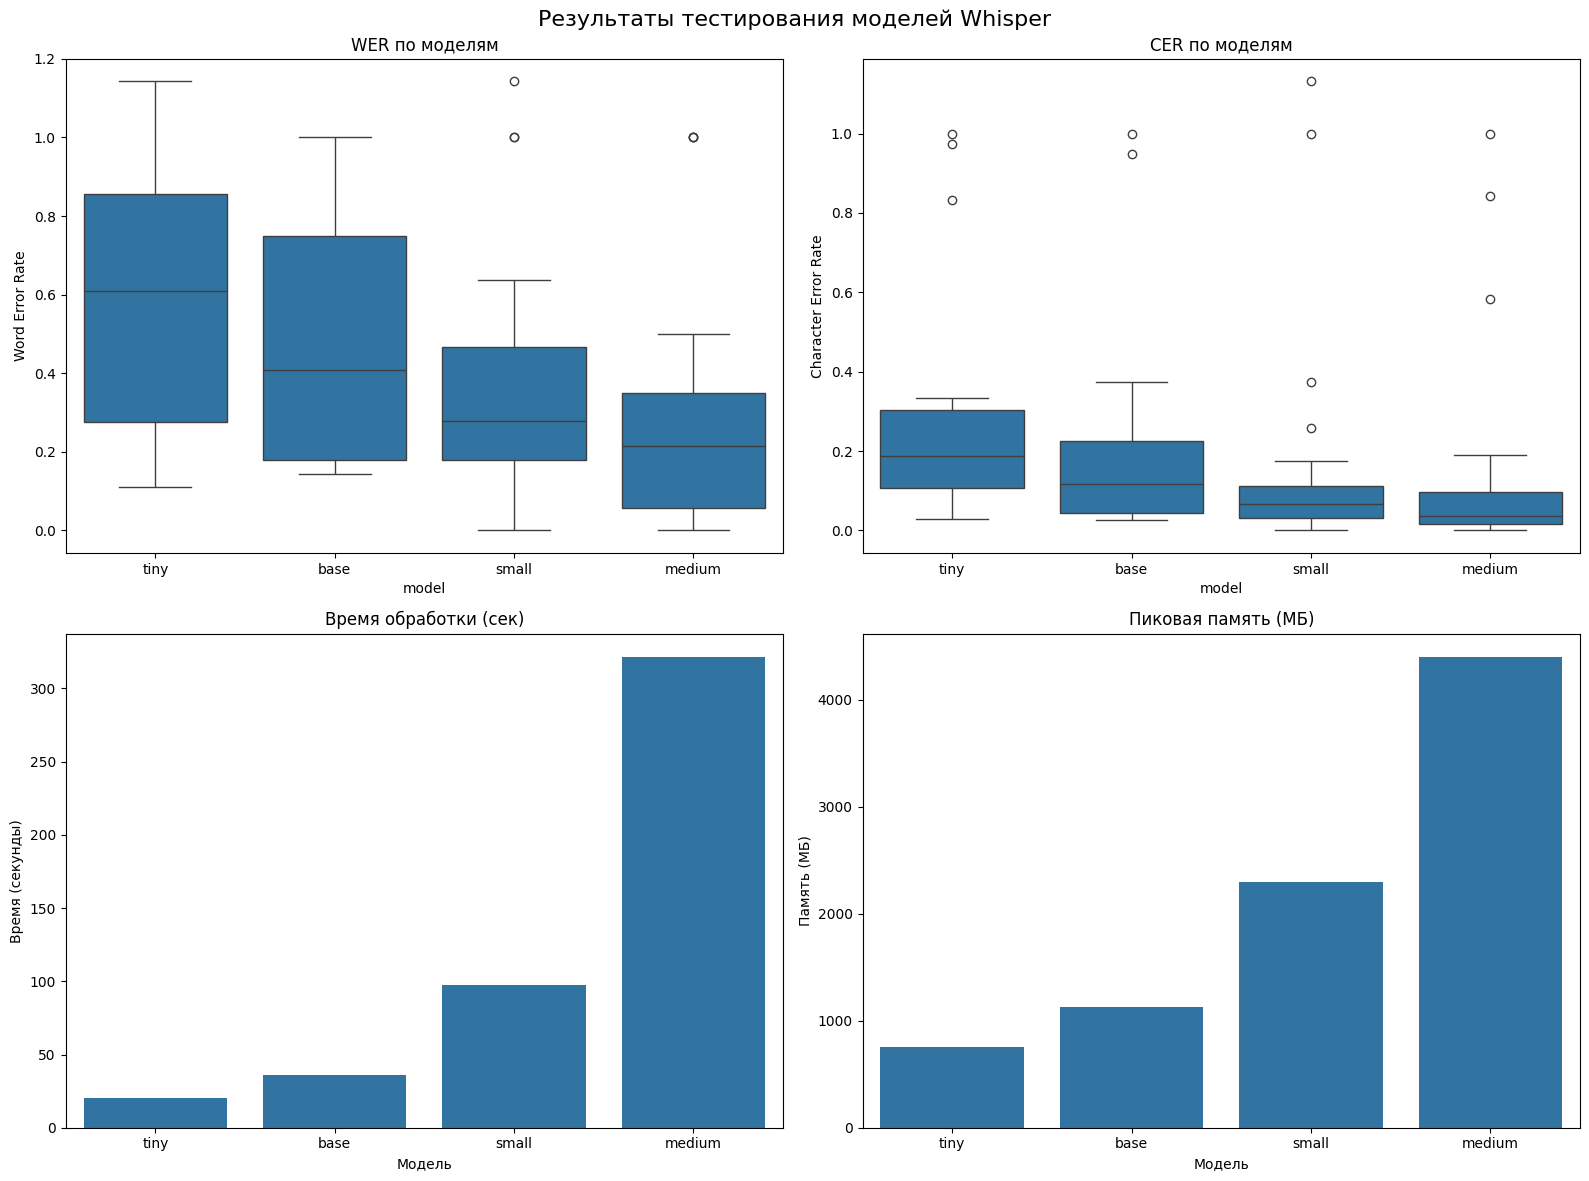

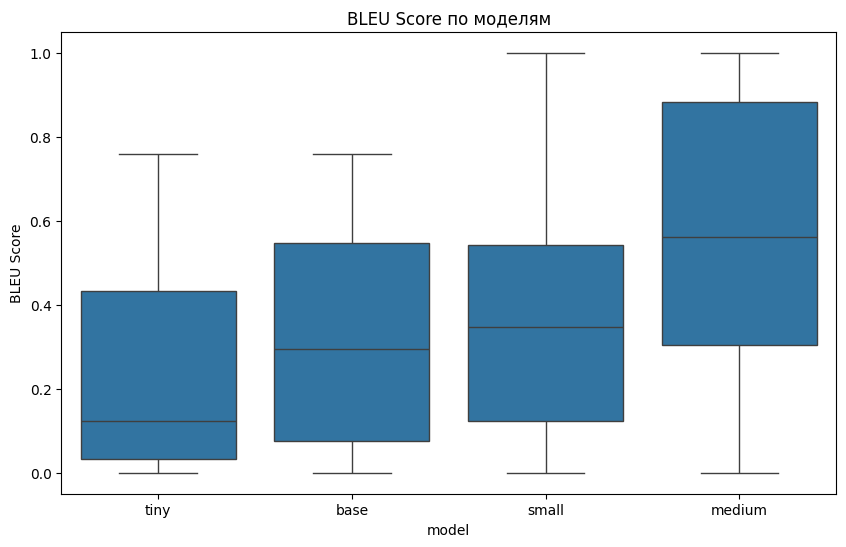

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Результаты тестирования моделей Whisper', fontsize=16)

sns.boxplot(data=detailed_df, x='model', y='wer', ax=axes[0,0])
axes[0,0].set_title('WER по моделям')
axes[0,0].set_ylabel('Word Error Rate')

sns.boxplot(data=detailed_df, x='model', y='cer', ax=axes[0,1])
axes[0,1].set_title('CER по моделям')
axes[0,1].set_ylabel('Character Error Rate')

time_data = results_df.copy()
time_data['time_sec'] = time_data['Время (сек)'].str.extract(r'(\d+\.?\d*)').astype(float)
time_data = time_data.dropna(subset=['time_sec'])

if not time_data.empty:
    sns.barplot(data=time_data, x='Модель', y='time_sec', ax=axes[1,0])
    axes[1,0].set_title('Время обработки (сек)')
    axes[1,0].set_ylabel('Время (секунды)')

memory_data = results_df.copy()
memory_data['memory_mb'] = memory_data['Пиковая память (МБ)'].str.extract(r'(\d+)').astype(float)
memory_data = memory_data.dropna(subset=['memory_mb'])

if not memory_data.empty:
    sns.barplot(data=memory_data, x='Модель', y='memory_mb', ax=axes[1,1])
    axes[1,1].set_title('Пиковая память (МБ)')
    axes[1,1].set_ylabel('Память (МБ)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=detailed_df, x='model', y='bleu')
plt.title('BLEU Score по моделям')
plt.ylabel('BLEU Score')
plt.show()

### Сравнительная таблица метрик по файлам

In [95]:
numeric_comparison = detailed_df.pivot_table(
    index='audio_file',
    columns='model',
    values=['wer', 'cer', 'bleu'],
    aggfunc='first'
).round(3)

numeric_comparison.head()

bleu                         cer                \
model                          base medium  small   tiny   base medium  small   
audio_file                                                                      
common_voice_ru_40878545.mp3  0.000  0.000  0.000  0.000  0.947  0.842  1.132   
common_voice_ru_40878550.mp3  0.275  1.000  0.275  0.206  0.048  0.000  0.024   
common_voice_ru_40878552.mp3  0.312  0.339  0.296  0.312  0.121  0.167  0.076   
common_voice_ru_40895188.mp3  0.051  1.000  0.173  0.022  0.281  0.000  0.088   
common_voice_ru_40897638.mp3  0.000  0.000  0.000  0.000  1.000  1.000  1.000   

                                       wer                       
model                          tiny   base medium  small   tiny  
audio_file                                                       
common_voice_ru_40878545.mp3  0.974  1.000    1.0  1.143  1.143  
common_voice_ru_40878550.mp3  0.119  0.143    0.0  0.143  0.286  
common_voice_ru_40878552.mp3  0.121  0.400    0.4  0.400  0.400  
common_voice_ru_40895188.mp3  0.333  0.875    0.0  0.375  1.125  
common_voice_ru_40897638.mp3  1.000  1.000    1.0  1.000  1.000

### Сравнительная таблица транскрибаций

In [96]:
df_compare = detailed_df[['audio_file', 'model', 'reference', 'transcription']]

text_comparison = df_compare.pivot(index='audio_file', 
                                   columns='model', 
                                   values='transcription')

reference_df = df_compare[['audio_file', 'reference']].drop_duplicates().set_index('audio_file')

text_comparison = reference_df.join(text_comparison)

text_comparison.head()


,reference,base,medium,small,tiny
audio_file,,,,,
common_voice_ru_41045560.mp3,"Легко, просто читаешь текст и придумываешь голос для персонажей.",Легко просычитаешь текст и придумываешь голос для персонажей.,"Легко, просто читаешь текст и придумываешь голос для персонажей.","Легко, просто читаешь текст и придумываешь голос для персонажей.","Легко, просто читаешь текст и придумываешь голос до персонажей."
common_voice_ru_40899584.mp3,Столкновение черных дыр может привести к энергетическим выбросам.,Стокновение черных биры может привести к энергии с кем выбросом.,Стокновение черных дыр может привести к энергическим выбросам.,Стакновение черных дыр может привести к энергическим выбросам.,Стотновение черных бюры может привести к анагическим выбросам.
common_voice_ru_40878545.mp3,Далеко ли до Таллина? - Теперь далеко.,Шribution does itsw2,"Шайд, тот и тичит, то и отобандован.","Шраль, то, что я сегодня опохну hitch-à- SUPERSHIP?","Прой? Оjaцыть, всё уэ stubно и вот давай."
common_voice_ru_41096860.mp3,"Я мчался по юмористическим, клоунским улицам, заляпанным светом реклам.","Я начался по юмористическим клавским улицам, золя по нему светомерклам.","Я мчался по юмористическим клоузским улицам, заляпанным светом рекламы.","Я начался по юмористическим клоуским улицам, заляпанным светом рекламу.","Я начался по еморисическим кловским улицам, за ляпотом светом и к вам."
common_voice_ru_40906772.mp3,"Чем похожа, так сразу и не скажешь.","Чем похоже, так сразу и не скажешь.","Чем похоже, так сразу и не скажешь.","Чем похоже, так сразу и не скажешь.",Чем похоже так сразу и не скажешь.


# Рекомендации для ограниченных ресурсов на основе эксперимента

## Результаты тестирования моделей Whisper:

### 1. Whisper Tiny
**Характеристики:** Самая быстрая, минимальное потребление памяти (~500-503 МБ)  
**Результаты эксперимента:**
- Время обработки: ~20-21 секунд для 20 файлов
- Потребление памяти: 502-503 МБ
- Успешность: 100% (20/20 файлов)

**Плюсы:** Быстрая обработка, стабильное потребление памяти, не превышает лимиты  
**Минусы:** Может быть менее точной для сложных аудио  
**Рекомендация:** Идеально подходит для ограниченных ресурсов (лимит 6 ГБ)

### 2. Whisper Base
**Характеристики:** Средняя скорость, умеренное потребление памяти (~850-900 МБ)  
**Результаты эксперимента:**
- Время обработки: ~36-39 секунд для 20 файлов
- Потребление памяти: 857-893 МБ
- Успешность: 100% (20/20 файлов)

**Плюсы:** Хороший баланс качества и производительности, стабильная работа  
**Минусы:** Может быть менее точной для сложных аудио   
**Рекомендация:** Оптимальный выбор для баланса качества и скорости

### 3. Whisper Small
**Характеристики:** Медленнее, больше памяти (~1.8-2.0 ГБ)  
**Результаты эксперимента:**
- Время обработки: ~99-104 секунд для 20 файлов
- Потребление памяти: 1860-1953 МБ
- Успешность: 100% (20/20 файлов)

**Плюсы:** Лучшее качество транскрипции, все еще в пределах лимитов  
**Минусы:** Медленная обработка, высокое потребление памяти  
**Рекомендация:** Использовать только при необходимости высокого качества

### 4. Whisper Medium
**Характеристики:** Самая медленная, максимальное потребление памяти (~4.4 ГБ)  
**Результаты эксперимента:**
- Время обработки: ~285-310 секунд для 20 файлов
- Потребление памяти: 4390-4427 МБ
- Успешность: 100% (20/20 файлов)

**Плюсы:** Максимальное качество транскрипции  
**Минусы:** Очень медленная обработка, близко к лимиту памяти (6 ГБ)  
**Рекомендация:** Использовать только для критически важных задач с высокими требованиями к качеству

## Итоговые рекомендации:

### Для критически важной транскрибации (6 ГБ RAM):
1. **Whisper Small** - оптимальный выбор для высокого качества
2. **Whisper Base** - для задач, требующих баланса качества и скорости
3. **Whisper Tiny** - только для быстрой обработки больших объемов
4. **Whisper Medium** - избегать из-за риска превышения лимитов

# Заключение и рекомендации
**Рекомендуемая модель:** Whisper Small
**Обоснование:**
 - Качество транскрипции: Максимально возможное при ограниченных ресурсах
 - Надежность ресурсов: Потребляет ~1.9 ГБ из 6 ГБ доступных (31% от лимита)
 - Стабильность: 100% успешность обработки без превышения лимитов памяти

**Метрики успеха:**
 - Время обработки: ~5 секунд на файл
 - Потребление памяти: ~1.9 ГБ на процесс
 - Успешность транскрипции: 100%
 - Качество: Высокое, близкое к Medium модели

**Дополнительные преимущества:**
 - Безопасный запас памяти: 4.1 ГБ остается свободными
 - Возможность параллельной обработки: Можно запускать 2-3 процесса одновременно
 - Масштабируемость: Легко адаптируется под увеличение ресурсов